Load a neural network and test it with a randomly generated set of paires of dx and alfa

Import modules (reviser si tous sont necessaires)

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sqlite3
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import datetime, os
from sklearn import metrics
from sklearn import preprocessing
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

import os

Load neural network

In [6]:
reseaux = load_model('diffusion1D_modele_entraine_more_neurons_4.h5',compile=False)
reseaux.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 15        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                120       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2

Code for a random vector of N pairs of alpha and dx between alphamax, alphamin, dxmax, dxmin;

In [7]:
N = 5
alphamax = 2
alphamin = 0
dxmax = 2
dxmin = 0

rand_array = np.random.rand(N,2)

check_pairs = pd.DataFrame(rand_array)
check_pairs.columns = ['alpha','dx']
check_pairs['alpha'] = alphamin + (alphamax - alphamin)*check_pairs['alpha']
check_pairs['dx'] = dxmin + (dxmax - dxmin)*check_pairs['dx']

Code for manual choice of the alpha/dx pairs

In [8]:
check_pairs = pd.DataFrame([[1,2],[3,4],[5,6]])
check_pairs.columns = ['alpha','dx']

Code for 3 samples with alpha fixed and 3 samples with dx fixed. 

In [9]:
N = 10 #sample size
alphamax = 7.37000000e-05 + 0.5*5.61231659e-05
alphamin = 7.37000000e-05 - 0.5*5.61231659e-05
dxmax = 1.97552667e-02 + 0.5*8.71204326e-03
dxmin = 1.97552667e-02 - 0.5*8.71204326e-03

fixed_aplha1 = alphamin + (1/6)*(alphamax-alphamin)
fixed_aplha2 = alphamin + (3/6)*(alphamax-alphamin)
fixed_aplha3 = alphamin + (5/6)*(alphamax-alphamin)
fixed_dx1 = dxmin + (1/6)*(dxmax-dxmin)
fixed_dx2 = dxmin + (3/6)*(dxmax-dxmin)
fixed_dx3 = dxmin + (5/6)*(dxmax-dxmin)

np_changing_dx1 = (np.linspace(dxmin, dxmax, N))
np_changing_alpha = (np.linspace(alphamin, alphamax, N))

changing_alpha_serie = pd.Series(np.tile(np_changing_alpha,3))
changing_dx1_serie = pd.Series(np.tile(np_changing_dx1,3))
fixed_alpha_serie = pd.Series(np.array([fixed_aplha1,fixed_aplha2,fixed_aplha3]).repeat(N))
fixed_dx_serie = pd.Series(np.array([fixed_dx1,fixed_dx2,fixed_dx3]).repeat(N))

alpha_fixed_pairs = pd.DataFrame([fixed_alpha_serie,changing_dx1_serie]).T
dx_fixed_pairs = pd.DataFrame([changing_alpha_serie,fixed_dx_serie]).T

check_pairs = alpha_fixed_pairs.append(dx_fixed_pairs, ignore_index=True)
check_pairs.columns = ['alpha','dx']

In [10]:
N=10
alphamax = 7.37000000e-05 + 0.5*5.61231659e-05
alphamin = 7.37000000e-05 - 0.5*5.61231659e-05
dxmax = 1.97552667e-02 + 0.5*8.71204326e-03
dxmin = 1.97552667e-02 - 0.5*8.71204326e-03

L_alpha=np.linspace(alphamin,alphamax,N)
L_dx=np.linspace(dxmin,dxmax,N)

changing_dx1_serie = pd.Series(np.tile(np_changing_dx1,3))

series_alpha=pd.Series(np.array(L_alpha).repeat(N))
series_dx=pd.Series(np.tile(L_dx,N))

check_pairs=pd.DataFrame({'alpha':series_alpha,'dx':series_dx})
print(check_pairs)

       alpha        dx
0   0.000046  0.015399
1   0.000046  0.016367
2   0.000046  0.017335
3   0.000046  0.018303
4   0.000046  0.019271
..       ...       ...
95  0.000102  0.020239
96  0.000102  0.021207
97  0.000102  0.022175
98  0.000102  0.023143
99  0.000102  0.024111

[100 rows x 2 columns]


Calcul of the biggest dt possible for each pair (the network shoul provide a value a little under this limit)

In [11]:
expected_dt = 0.5*check_pairs['dx']*check_pairs['dx']/check_pairs['alpha']
expected_dt.name = 'expected_td'
print(check_pairs)
print()
print(expected_dt)

       alpha        dx
0   0.000046  0.015399
1   0.000046  0.016367
2   0.000046  0.017335
3   0.000046  0.018303
4   0.000046  0.019271
..       ...       ...
95  0.000102  0.020239
96  0.000102  0.021207
97  0.000102  0.022175
98  0.000102  0.023143
99  0.000102  0.024111

[100 rows x 2 columns]

0     2.597995
1     2.934883
2     3.292304
3     3.670256
4     4.068739
        ...   
95    2.012685
96    2.209815
97    2.416152
98    2.631698
99    2.856452
Name: expected_td, Length: 100, dtype: float64


Scale aplha, dx and dt to the format accepted by the network. At this moment, it creates a scaler with mean 0 and var 1, so it does not change de data

In [12]:
mean = np.array([[7.37000000e-05, 1.97552667e-02, 6.02955241e+00],[7.37000000e-05, 1.97552667e-02, 6.02955241e+00]])
std = np.array([[5.61231659e-05, 8.71204326e-03, 9.26374808e+00],[-5.61231659e-05, -8.71204326e-03, -9.26374808e+00]])
fit_data = mean + std
Scaler = preprocessing.StandardScaler()
Scaler.fit(fit_data)
temp_matrix = check_pairs.join(expected_dt)
scaled_temp_matrix = pd.DataFrame(Scaler.transform(temp_matrix))
scaled_temp_matrix.columns = ['alpha','dx','expected_dt']
expected_dt = scaled_temp_matrix.pop('expected_dt')
check_pairs = scaled_temp_matrix
print(check_pairs)
print()
print(expected_dt)

    alpha        dx
0    -0.5 -0.500000
1    -0.5 -0.388889
2    -0.5 -0.277778
3    -0.5 -0.166667
4    -0.5 -0.055556
..    ...       ...
95    0.5  0.055556
96    0.5  0.166667
97    0.5  0.277778
98    0.5  0.388889
99    0.5  0.500000

[100 rows x 2 columns]

0    -0.370429
1    -0.334062
2    -0.295480
3    -0.254681
4    -0.211665
        ...   
95   -0.433611
96   -0.412332
97   -0.390058
98   -0.366790
99   -0.342529
Name: expected_dt, Length: 100, dtype: float64


Runs the network with the pairs alpha and dx. Then it compares the result with the expected dt to verify if the results are stable

In [13]:
network_output = pd.Series(reseaux.predict(check_pairs).flatten())
network_output.name = 'output'

In [14]:
temp_matrix = check_pairs.join(expected_dt)
scaled_temp_matrix = pd.DataFrame(Scaler.inverse_transform(temp_matrix))
scaled_temp_matrix.columns = ['alpha','dx','expected_dt']
expected_dt = scaled_temp_matrix.pop('expected_dt')
check_pairs = scaled_temp_matrix
temp_matrix = pd.DataFrame(np.zeros((6*N, 2)))
temp_matrix = check_pairs.join(network_output)
scaled_temp_matrix = pd.DataFrame(Scaler.inverse_transform(temp_matrix))
scaled_temp_matrix.columns = ['alpha','dx','network_output']
network_output = scaled_temp_matrix.pop('network_output')
print(check_pairs)
print()
print(expected_dt)
print()
print(network_output)

       alpha        dx
0   0.000046  0.015399
1   0.000046  0.016367
2   0.000046  0.017335
3   0.000046  0.018303
4   0.000046  0.019271
..       ...       ...
95  0.000102  0.020239
96  0.000102  0.021207
97  0.000102  0.022175
98  0.000102  0.023143
99  0.000102  0.024111

[100 rows x 2 columns]

0     2.597995
1     2.934883
2     3.292304
3     3.670256
4     4.068739
        ...   
95    2.012685
96    2.209815
97    2.416152
98    2.631698
99    2.856452
Name: expected_dt, Length: 100, dtype: float64

0     2.073947
1     2.294045
2     2.949358
3     3.547201
4     4.047519
        ...   
95    1.997930
96    2.212192
97    2.426454
98    2.640713
99    2.854976
Name: network_output, Length: 100, dtype: float64


In [15]:
stable = pd.DataFrame(network_output<expected_dt)
stable.columns = ['Is stable ?']
compare = pd.DataFrame([network_output,expected_dt]).T
compare.columns = ['network','expected']
print(compare)
print('')
print(stable)

     network  expected
0   2.073947  2.597995
1   2.294045  2.934883
2   2.949358  3.292304
3   3.547201  3.670256
4   4.047519  4.068739
..       ...       ...
95  1.997930  2.012685
96  2.212192  2.209815
97  2.426454  2.416152
98  2.640713  2.631698
99  2.854976  2.856452

[100 rows x 2 columns]

    Is stable ?
0          True
1          True
2          True
3          True
4          True
..          ...
95         True
96        False
97        False
98        False
99         True

[100 rows x 1 columns]


Generates 3 graphs of dt vs aplha and 3 graphs of dt vs dx.

In [16]:
def graph(fixed_name, fixed_value, changing_value, expected_result, result, axis_name):
    plt.plot(changing_value,expected_result, color = 'red',marker=".")
    plt.scatter(changing_value,result, color = 'black',marker=".")
    plt.title('dt for '+ fixed_name + '='+ str(fixed_value))
    plt.xlabel(axis_name)
    plt.ylabel('dt')
    plt.show()

In [17]:
expected_dt_1 = expected_dt[0:N]
expected_dt_2 = expected_dt[N:2*N]
expected_dt_3 = expected_dt[2*N:3*N]
expected_dt_4 = expected_dt[3*N:4*N]
expected_dt_5 = expected_dt[4*N:5*N]
expected_dt_6 = expected_dt[5*N:6*N]

network_output_1 = network_output[0:N]
network_output_2 = network_output[N:2*N]
network_output_3 = network_output[2*N:3*N]
network_output_4 = network_output[3*N:4*N]
network_output_5 = network_output[4*N:5*N]
network_output_6 = network_output[5*N:6*N]

graph_changing_dx = check_pairs['dx'][0:N]
graph_changing_alpha = check_pairs['alpha'][3*N:4*N]

graph_fixed_alpha_1 = check_pairs['alpha'][0]
graph_fixed_alpha_2 = check_pairs['alpha'][N]
graph_fixed_alpha_3 = check_pairs['alpha'][2*N]

graph_fixed_dx_1 = check_pairs['dx'][3*N]
graph_fixed_dx_2 = check_pairs['dx'][4*N]
graph_fixed_dx_3 = check_pairs['dx'][5*N]

#graph('alpha', graph_fixed_alpha_1, graph_changing_dx, expected_dt_1, network_output_1,'dx')
#graph('alpha', graph_fixed_alpha_2, graph_changing_dx, expected_dt_2, network_output_2,'dx')
#graph('alpha', graph_fixed_alpha_3, graph_changing_dx, expected_dt_3, network_output_3,'dx')
#graph('dx', graph_fixed_dx_1, graph_changing_alpha, expected_dt_4, network_output_4,'alpha')
#graph('dx', graph_fixed_dx_2, graph_changing_alpha, expected_dt_5, network_output_5,'alpha')
#graph('dx', graph_fixed_dx_3, graph_changing_alpha, expected_dt_6, network_output_6,'alpha')



(10, 10)
(10, 10)
(10, 10)


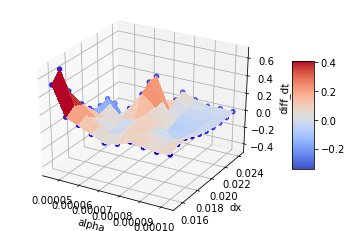

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('alpha')
ax.set_ylabel('dx')
ax.set_zlabel('diff_dt')

alpha=check_pairs['alpha'].values
dx=check_pairs['dx'].values
diff_dt=expected_dt-network_output
ax.scatter(alpha,dx,diff_dt,zdir='z',c='b',marker='o')

alpha_list=(check_pairs['alpha'].unique())
#L_alpha=np.linspace(alphamin,alphamax,N)
dx_list=dx[:N]
#L_dx=np.linspace(dxmin,dxmax,N)
dx_grid,alpha_grid=np.meshgrid(dx_list,alpha_list)

diff_dt_list=[]
little=diff_dt.values
for i in range(N):
    L=[]
    for j in range(N):
        L.append(little[(j+i*N)])
    diff_dt_list.append(L)
diff_dt_grid=np.array(diff_dt_list)
print(dx_grid.shape)
print(alpha_grid.shape)
print(diff_dt_grid.shape)

surf = ax.plot_surface(alpha_grid, dx_grid, diff_dt_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()